In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# Variational Inference Examples

## Objectives

+ to introduce variational inference as a class of techniques for approximate Bayesian Inference. 
+ to use automatic differentiation variational inference (ADVI) for performing Bayesian inference, using `PyMC3`.

## References 

+ The corresponding reading activity.
+ [Variational Inference: A Review for Statisticians (Blei et al, 2018)](https://arxiv.org/pdf/1601.00670.pdf).
+ [Automatic Differentiation Variational Inference (Kucukelbir et al, 2016)]( https://arxiv.org/pdf/1603.00788.pdf).
+ [Autoencoding Variational Bayes (Kingma and Welling, 2014)](https://arxiv.org/pdf/1312.6114.pdf).
+ [Black Box Variational Inference (Ranganath et al, 2013)](https://arxiv.org/pdf/1401.0118.pdf).
+ [Stein Variational Gradient Descent (Liu and Wang, 2016)](https://arxiv.org/pdf/1608.04471.pdf).
+ [Variational Inference with Normalizing Flows (Rezende and Mohamed, 2016)](https://arxiv.org/pdf/1505.05770.pdf).

**Note:** This notebook was originally developed by [Dr. Rohit Tripathy](https://rohittripathy.netlify.com).

## Example 1 - normal-normal model

Let's demonstrate the VI process end-to-end with a simple example.
Consider the task of inferring the gravitational constant from data. 
We perform an experiment $X_n$ that measures the acceleration of gravity and that we know that the measurement standard deviation is $\sigma = 0.1$.
Here are some synthetic data.

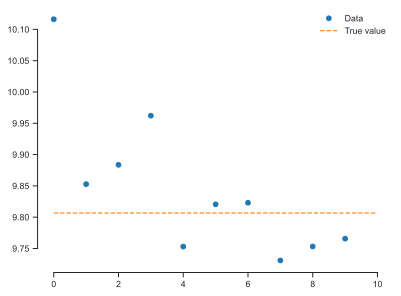

In [2]:
import scipy.constants
g_true = scipy.constants.g
# Generate some synthetic data
N = 10
sigma = 0.1
data = g_true + sigma * np.random.randn(N)

plt.plot(np.arange(N), data, 'o', label='Data')
plt.plot(np.linspace(0, N, 100), g_true*np.ones(100), '--', label='True value')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True)

The likelihood of the data is:

$$
X_n | g, \sigma \sim N(g, \sigma^2).
$$

So, the model says that the measured acceleration of gravity is around the true one with some Gaussian noise.
Assume that our prior state-of-knowledge over $g$ is:

$$
g | g_0, s_0 \sim N(g_0, s_0^2),
$$

with known $g_0 = 10$, $s_0 = 0.4$.
This is a, so-called, [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) and the posterior over $g$ is given analytically by:

$$
g|X \sim N(\tilde{g}, \tilde{s}^2),
$$

where, $\tilde{s}^2 = \left( \frac{N}{\sigma^2} + \frac{1}{s_0^2} \right)^{-1}$ and $\tilde{g} = \tilde{s}^2 \left( \frac{g_0}{s_0^2} + \frac{\sum_{i=1}^{N} X_i}{\sigma^2}\right)$.
Let's write some code to get this analytical posterior:

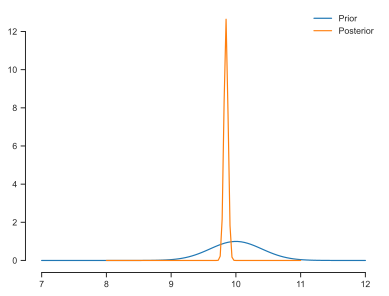

In [3]:
def post_mean_and_variance(prior_mean, prior_variance, data, likelihood_var):
    N = len(data)
    sigma2 = likelihood_var
    s02 = prior_variance
    m0 = prior_mean
    sumdata = np.sum(data)
    post_prec = (N/sigma2) + (1./s02)
    post_var = 1./post_prec
    post_mean = post_var * ((m0/s02) + (sumdata/sigma2))
    return post_mean, post_var

gtilde, s2tilde = post_mean_and_variance(10., 0.4**2, data, 0.1**2)

xs1 = np.linspace(7, 12, 100)
xs2 = np.linspace(8, 11, 100)
plt.plot(xs1, st.norm(loc=10., scale=0.4).pdf(xs1), label='Prior')
plt.plot(xs2, st.norm(loc=gtilde, scale=np.sqrt(s2tilde)).pdf(xs2), label='Posterior')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Now let's try to infer the posterior over $g$ using VI. Let specify our joint log probability model first.
We will use yet another automatic differentiation package: [autograd](https://github.com/HIPS/autograd).

In [5]:
from autograd.scipy.stats.norm import logpdf as normlogpdf
from autograd import grad, elementwise_grad as egrad 
from autograd import numpy as anp
from autograd.numpy import random as npr
from autograd.misc.optimizers import adam 

g0, s0 = 10., 0.4
sigma = 0.1

def logprior(g):
    return normlogpdf(g, g0, s0)

def loglikelihood(g):
    return anp.sum(normlogpdf(data, g, sigma))

def logjoint(g):
    return logprior(g) + loglikelihood(g)

In [15]:
import torch


g0 = torch.tensor(10.)
s0 = torch.tensor(0.4)
sigma = torch.tensor(0.1)

def logprior(g):
    return torch.distributions.Normal(g0, s0).log_prob(g)

def loglikelihood(g):
    return torch.distributions.Normal(g, sigma).log_prob(data).sum()

def logjoint(g):
    return logprior(g) + loglikelihood(g)

Now we need to specify a parameterized approximate posterior, $q_{\phi}(\cdot)$. The obvious choice here is a Gaussian:

$$
q_{\phi}(g) = N(g | \phi_1, \exp(\phi_2)^2),
$$

where, $\phi = (\phi_1, \phi_2)$ are the variational parameters. The ELBO needs to be maximized wrt to $\phi$. Let go ahead and set up the ELBO. Recall that the ELBO is given by:

$$
\mathcal{L}(\phi) =  \mathbb{E}_{q(\theta)}[\log p(\theta, \mathcal{D})] + \mathbb{H}[q(\theta)].
$$

To optimize the ELBO, we will need to compute an expectation over the variational distribution $q$ (first term on the RHS in the above equation). This cannot be done analytically. Instead, we resort to a Monte Carlo approximation:

$$
\mathbb{E}_q [\log p(\theta, \mathbf{x})] \approx \frac{1}{S}\sum_{s=1}^{S}   \log p(\theta^{(s)}, \mathbf{x}),
$$

where the samples $\theta^{(s)}$ are drawn from $q$.

In [6]:
def norm_entropy(s):
    s2 = s*s
    return 0.5 * (1. + anp.log(2.*anp.pi*s2))

def ELBO(phi, num_samples):
    m, s = phi[0], anp.exp(phi[1])
    
    # compute the entropy 
    entropy = norm_entropy(s)
    
    # compute the avg. datafit
    samples = m + s*npr.randn(num_samples)
    datafit = 0.
    for sample in samples:
        datafit += logjoint(sample)
    datafit = datafit/num_samples
    
    # return the elbo
    elbo = datafit + entropy
    return elbo

def negELBO(phi, num_samples=5):
    return -ELBO(phi, num_samples)

In [ ]:
def norm_entropy(s):
    s2 = s*s
    return 0.5 * (1. + torch.log(2.*torch.pi*s2))

def ELBO(phi, num_samples):
    m, s = phi[0], torch.exp(phi[1])

    # compute the entropy
    entropy = norm_entropy(s)

    # compute the avg. datafit
    samples = m + s*npr.randn(num_samples)
    datafit = 0.

Now let's optimize the lower bound using simple stochastic gradient descent (SGD).

In [7]:
# get the gradient of the negative elbo 
gradnegelbo = grad(negELBO)

# give initial values to the variational parameters 
phi_init = anp.array([9., -1.])

# optimize 
num_iter = 1000
phi_i = phi_init
step_size = 1e-3
num_samples = 10
elbos = []
bestnegelbo = np.inf
for i in range(num_iter):
    negelbo = negELBO(phi_i, num_samples)
    elbos.append(-negelbo)
    grad_i = gradnegelbo(phi_i, num_samples)
    phi_next = phi_i - step_size*grad_i
    
    if (i+1)%50 == 0:
        print('Iteration [%4d] : ELBO = %.5f'%(i+1, -negelbo))
        if negelbo < bestnegelbo:
            phi_opt = phi_i
            bestnegelbo = negelbo   
    phi_i = phi_next

Iteration [  50] : ELBO = 3.55260
Iteration [ 100] : ELBO = 2.16025
Iteration [ 150] : ELBO = 4.65791
Iteration [ 200] : ELBO = 3.90420
Iteration [ 250] : ELBO = 5.67582
Iteration [ 300] : ELBO = 3.05132
Iteration [ 350] : ELBO = 5.35149
Iteration [ 400] : ELBO = 4.91728
Iteration [ 450] : ELBO = 5.38082
Iteration [ 500] : ELBO = 4.87880
Iteration [ 550] : ELBO = 4.95459
Iteration [ 600] : ELBO = 4.82771
Iteration [ 650] : ELBO = 5.28595
Iteration [ 700] : ELBO = 5.04306
Iteration [ 750] : ELBO = 5.01758
Iteration [ 800] : ELBO = 5.03613
Iteration [ 850] : ELBO = 4.85189
Iteration [ 900] : ELBO = 5.18194
Iteration [ 950] : ELBO = 4.93463
Iteration [1000] : ELBO = 5.29431


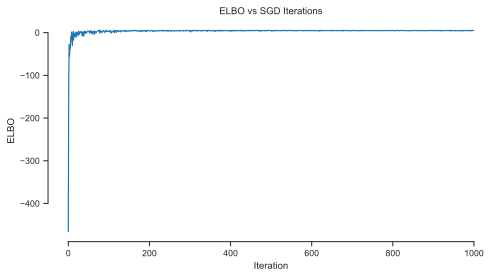

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(num_iter), elbos)
plt.title('ELBO vs SGD Iterations')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
sns.despine(trim=True)

In [10]:
# get the posterior distribution
postmean = phi_opt[0]
poststdev = np.exp(phi_opt[1])
gpost = st.norm(postmean, poststdev)

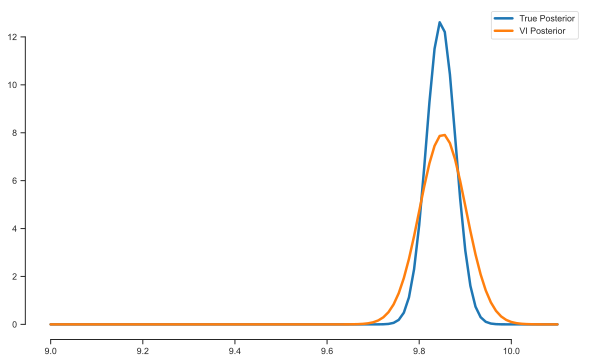

In [11]:
# compare the VI posterior with the analytical distribution
xs = np.linspace(9, 10.1, 100)
plt.figure(figsize=(10, 6))
plt.plot(xs, st.norm(loc=gtilde, scale=np.sqrt(s2tilde)).pdf(xs), label='True Posterior', linewidth=2.5)
plt.plot(xs, gpost.pdf(xs), label='VI Posterior', linewidth=2.5)
plt.legend(loc='best')
sns.despine(trim=True);

As you can see our approximation of the posterior is not exact, but close. The normal-normal model is a very simple example with 1 latent variable.  In practice setting up the variational posterior for all latent variables, keeping track of transformations and optimizing the variational parameters can become highly tedious for models of any reasonable level of complexity. From this point on, we will use `PyMC3`'s ADVI capabilities.  

## Example 2 - Coin-toss example 

Just like in the MCMC lecture, let's look at the process of setting up a model and performing variational inference and diagnostics with the coin toss example.  

The probabilistic model is as follows. We observe binary coin toss data:

$$
x_i|\theta \overset{\mathrm{i.i.d.}}{\sim} \mathrm{Bernoulli}(\theta),
$$

for $i=1, \dots, N$.

The prior over the latent variable $\theta$ is a Beta distribution:

$$
\theta \sim \mathrm{Beta}([2, 2]).
$$

We assign the prior as a Beta distribution with shape parameters 2 and 2, corresponding to a weak apriori belief that the coin is most likely fair.

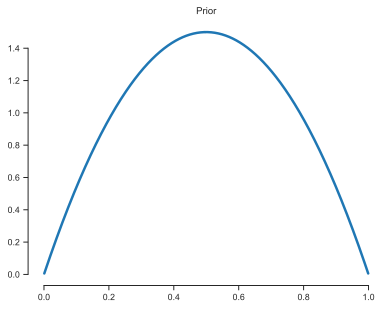

In [12]:
thetaprior = st.beta(2., 2.)
x = np.linspace(0.001, 0.999, 1000)
plt.plot(x, thetaprior.pdf(x), linewidth=2.5)
plt.title('Prior')
sns.despine(trim=True);

We wish to perform posterior inference on $\theta$:

$$
p(\theta| x_1, \dots, x_N) \propto p(\theta) \prod_{i=1}^{N} p(x_i | \theta).
$$

Since this is a conjugate model, we know the posterior in closed form:

$$
\theta | x_1, \dots, x_N = \mathrm{Beta}(\theta, 2+ \sum_{i=1}^N x_i, 2 + N - \sum_{i=1}^Nx_i )
$$

Let's generate some fake data and get the analytical posterior for comparison.

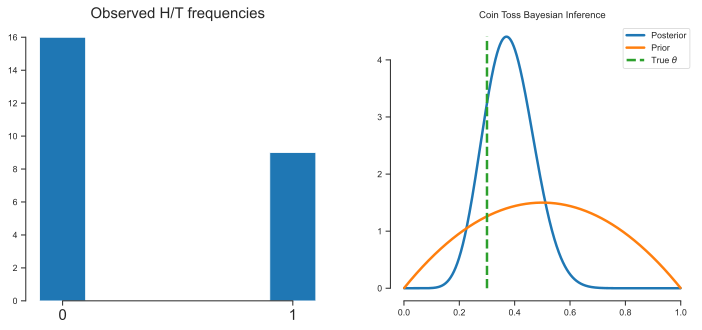

In [13]:
thetatrue =0.3
N = 25
data = np.random.binomial(1, thetatrue, size=(N,))
nheads = data.sum()
ntails = N - nheads
theta_post = st.beta(2. + nheads, 2. + ntails)

# plot data 
plt.figure(figsize=(12, 5))
plt.subplot(121)
_=plt.bar(*np.unique(data, return_counts=True), width=0.2)
_=plt.xticks([0, 1], fontsize=15)
_=plt.title('Observed H/T frequencies', fontsize = 15)

# plot posterior
plt.subplot(122)
x = np.linspace(0.001, 0.999, 1000)
postpdf = theta_post.pdf(x)
y = np.linspace(0., np.max(postpdf), 100)
plt.plot(x, postpdf, linewidth=2.5, label='Posterior')
plt.plot(x, thetaprior.pdf(x), linewidth=2.5, label='Prior')
plt.plot(thetatrue*np.ones_like(y), y, linewidth=2.5, linestyle='--', label='True $\\theta$')
plt.legend(loc='best')
plt.xticks()
plt.title('Coin Toss Bayesian Inference')
sns.despine(trim=True);

In [14]:
import pyro
import pyro.distributions as dist

def model(data):
    theta = pyro.sample('theta', dist.Beta(2., 2.))
    with pyro.plate('data', len(data)):
        pyro.sample('obs', dist.Bernoulli(theta), obs=data)

Now let's setup the `PyMC3` model and do variational inference. To do this, we simply need to setup the model like in the MCMC setup, and call `pymc3.variational.ADVI` to do inference.

In [14]:
model = pm.Model()
with model:
    theta = pm.Beta('theta', 2., 2.)
    x = pm.Bernoulli('x', theta, observed=data)
model

In [15]:
num_iter = 20000
num_samples = 20
with model:
    method = pm.ADVI()  # <- This method makes q a diagonal Gaussian
    #method = pm.FullRankADVI() # <- this method makes q a Gaussian with full rank cov. matrix
    #method = pm.SVGD() # <- Stein Variational Gradient descent (see additional readings)
    #method = pm.NFVI() # <- Normalizing flow Variational inference (see additional readings)
    vi_approx = pm.fit(n=num_iter, 
                       method=method,
                       progressbar=True, 
                       obj_n_mc=num_samples)

Finished [100%]: Average Loss = 17.924


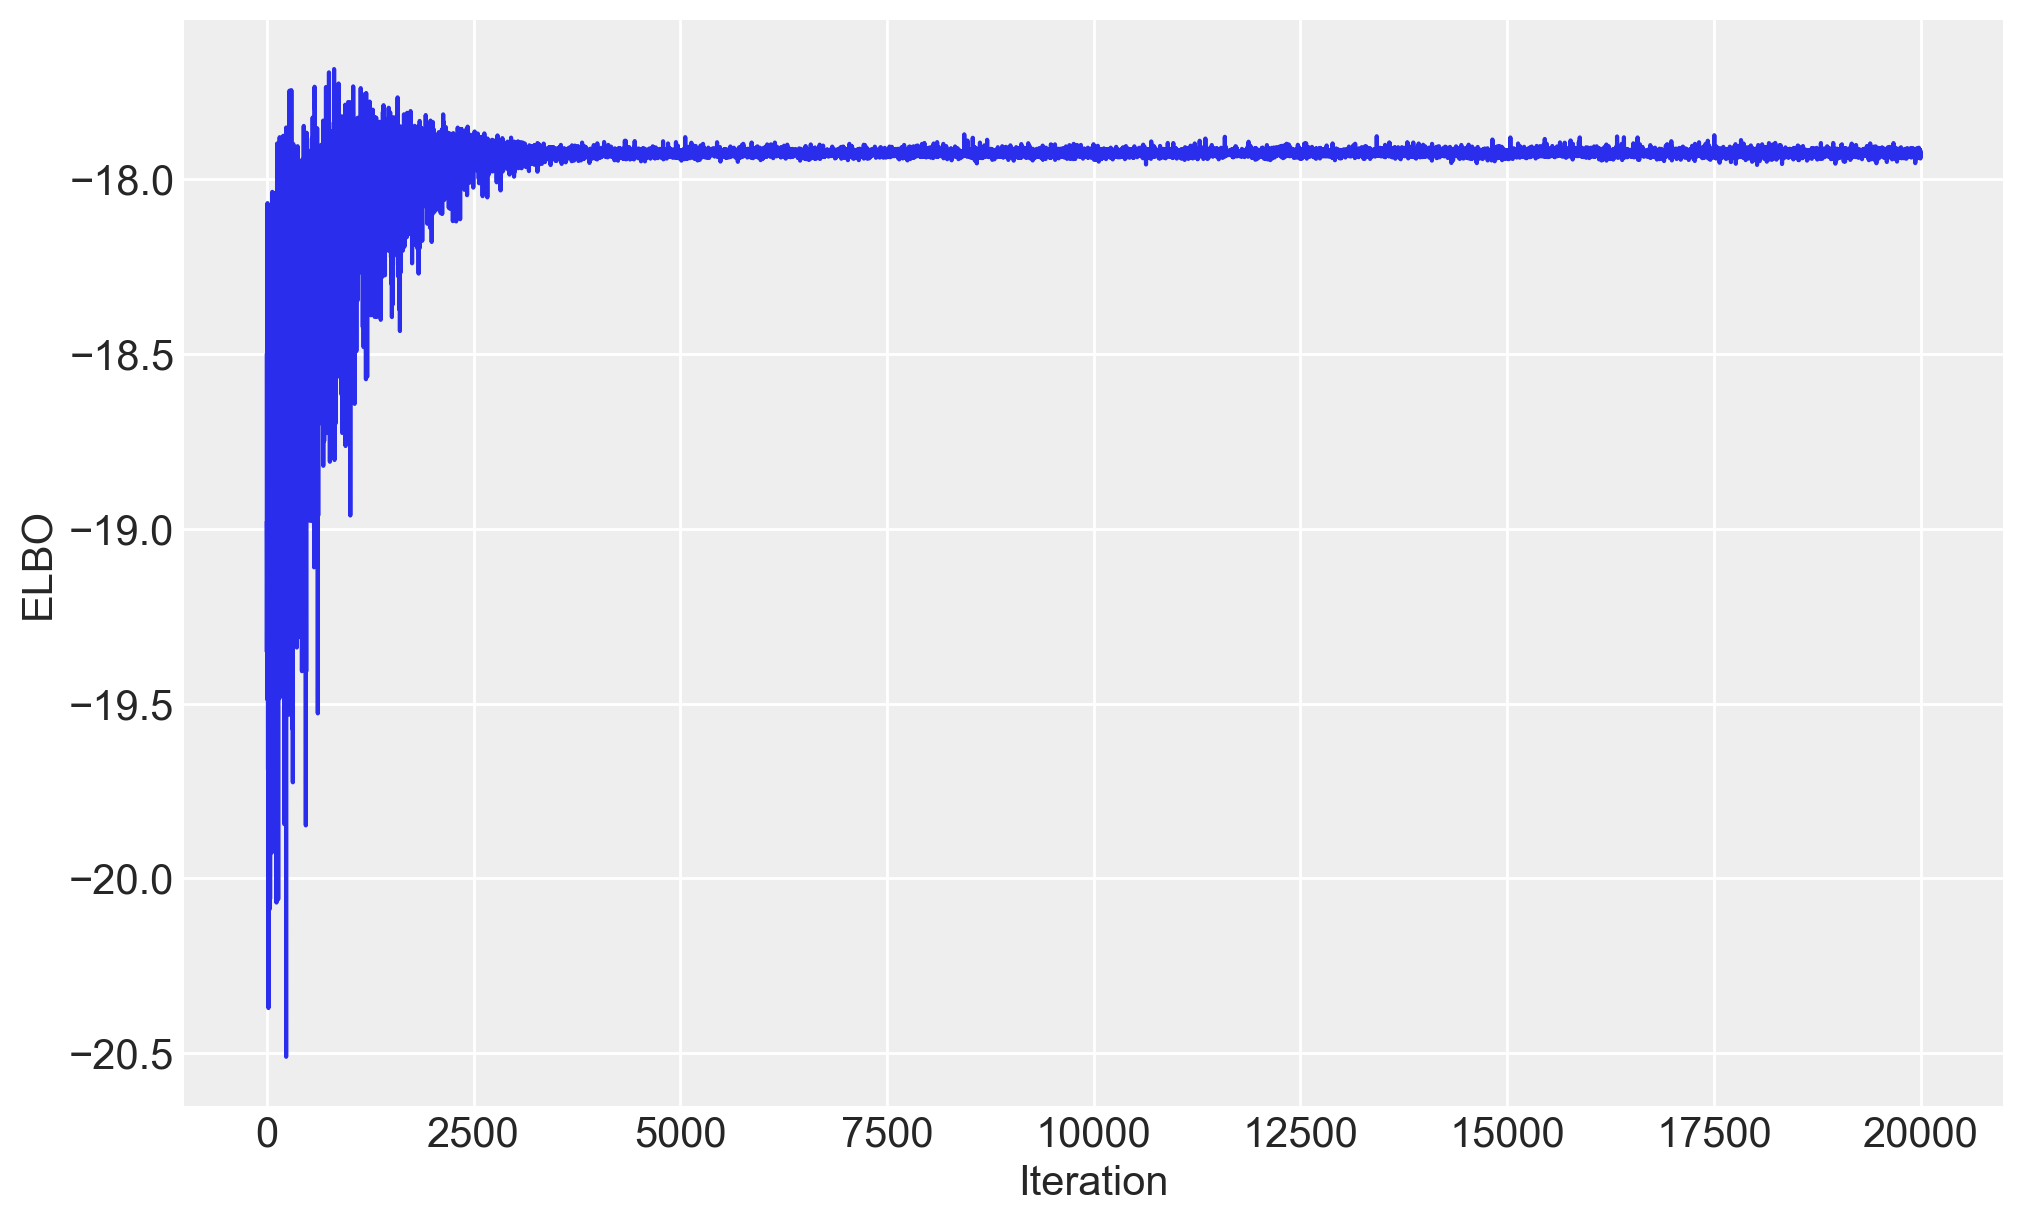

In [16]:
# Let's check the optimization convergence 
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_iter), -vi_approx.hist)
plt.ylabel('ELBO', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15);

Clearly, we see that the optimization has converged. 

Recall that ADVI transforms every variable with finite support with an invertible function to obtain a variable with support over the entire $\mathbb{R}$. The variational posterior is then set to be a diagonal Gaussian. 
In the coin toss problem, the latent variable $\theta \in (0, 1)$ is transformed with the logit function $g(\theta ) = \log \frac{\theta}{1 - \theta}$, i.e., `PyMC3` works with the transformed variable $\tilde{\theta} = g(\theta)$. 
The posterior over $\tilde{\theta}$ is then approximated with a Gaussian $q_{\phi}(\tilde{\theta}) = \mathcal{N}(\mu, \sigma^2)$, where, $\phi = (\mu, \sigma)$ are the variational parameters. Let's get these parameters and visualize the posterior. 

In [17]:
# get the variational parameters a
mu, sigma = vi_approx.mean.eval(), vi_approx.std.eval()
qtheta_transformed = pm.Normal.dist(mu, sigma)
transform = pm.transforms.logodds
def qthetalogp(x):
    x = tt.as_tensor(x)
    y = transform.forward(x)
    logpy = qtheta_transformed.logp(y)
    logpx = logpy + transform.jacobian_det(x)
    return logpx.eval()

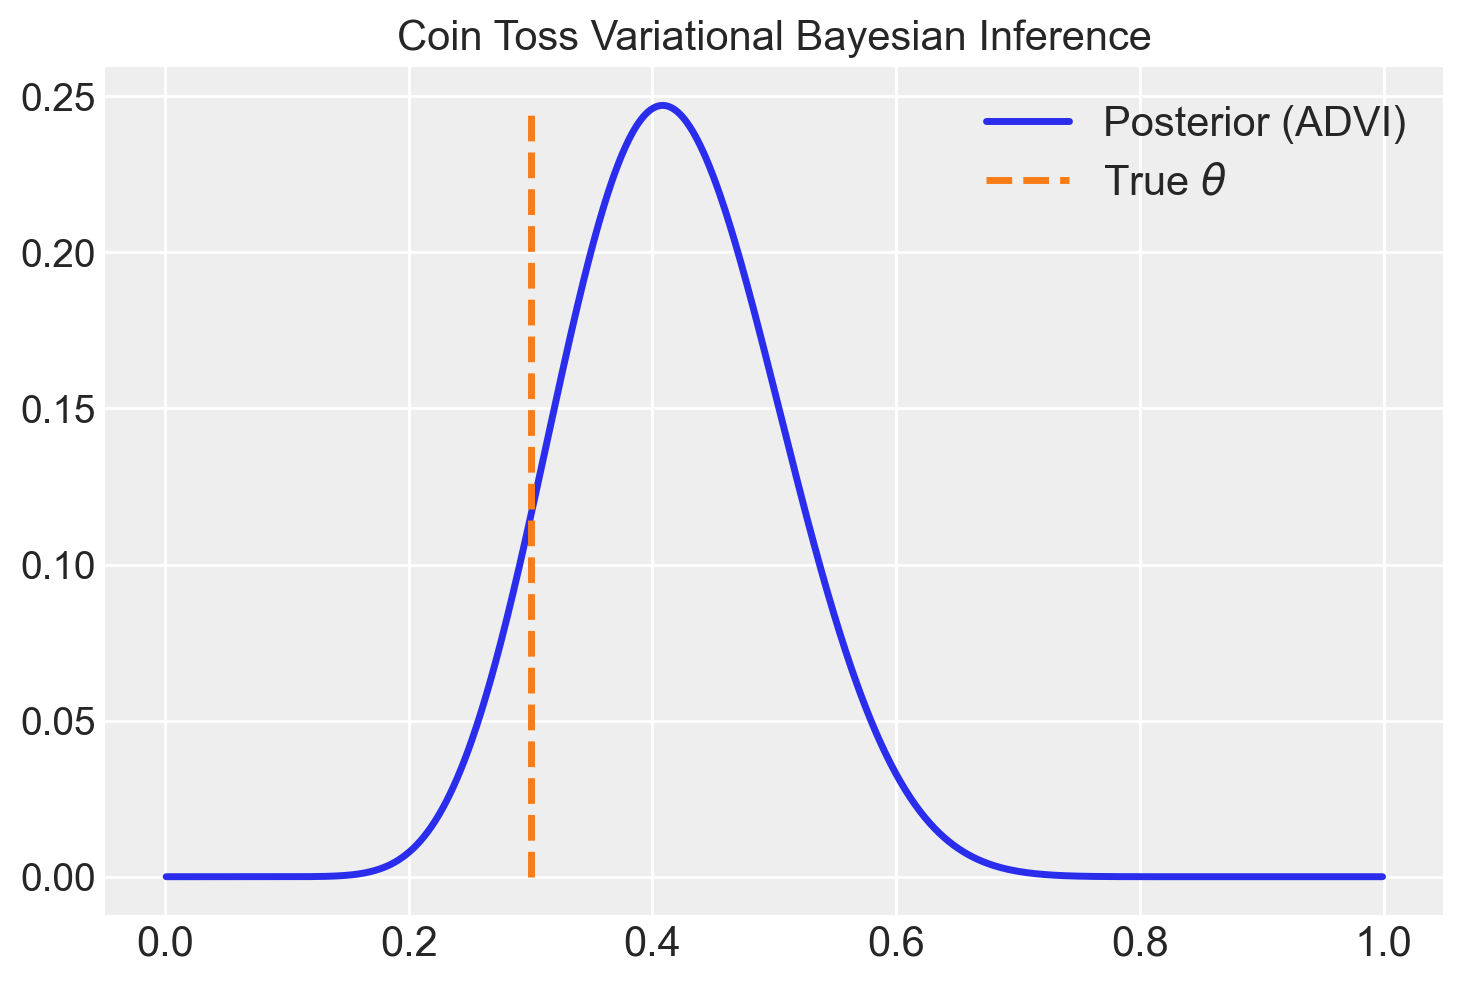

In [18]:
x = np.linspace(0.001, 0.999, 1000)
postpdf = theta_post.pdf(x)
postpdf_vi = np.exp(qthetalogp(x))
y = np.linspace(0., np.max(postpdf_vi), 100)
plt.plot(x, postpdf_vi, linewidth=2.5, label='Posterior (ADVI)')
plt.plot(thetatrue*np.ones_like(y), y, linewidth=2.5, linestyle='--', label='True $\\theta$')
plt.legend(loc='best', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Coin Toss Variational Bayesian Inference', fontsize = 15);

###  Posterior predictive distribution

To estimate posterior predictive expectations, we first create a `MultiTrace` object out of the results of the ADVI stored in `vi_approx`.  

In [19]:
trace = vi_approx.sample(2000)

From this point all of the computation is exactly as it was when doing MCMC. Let's generate some synthetic datasets from the posterior predictive distribution.

In [20]:
pp_samples = pm.sample_posterior_predictive(trace=trace, samples=500, model=model)
x_post = pp_samples['x']
x_post.shape # num samples of theta \times size of the dataset 

/opt/homebrew/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(500, 25)

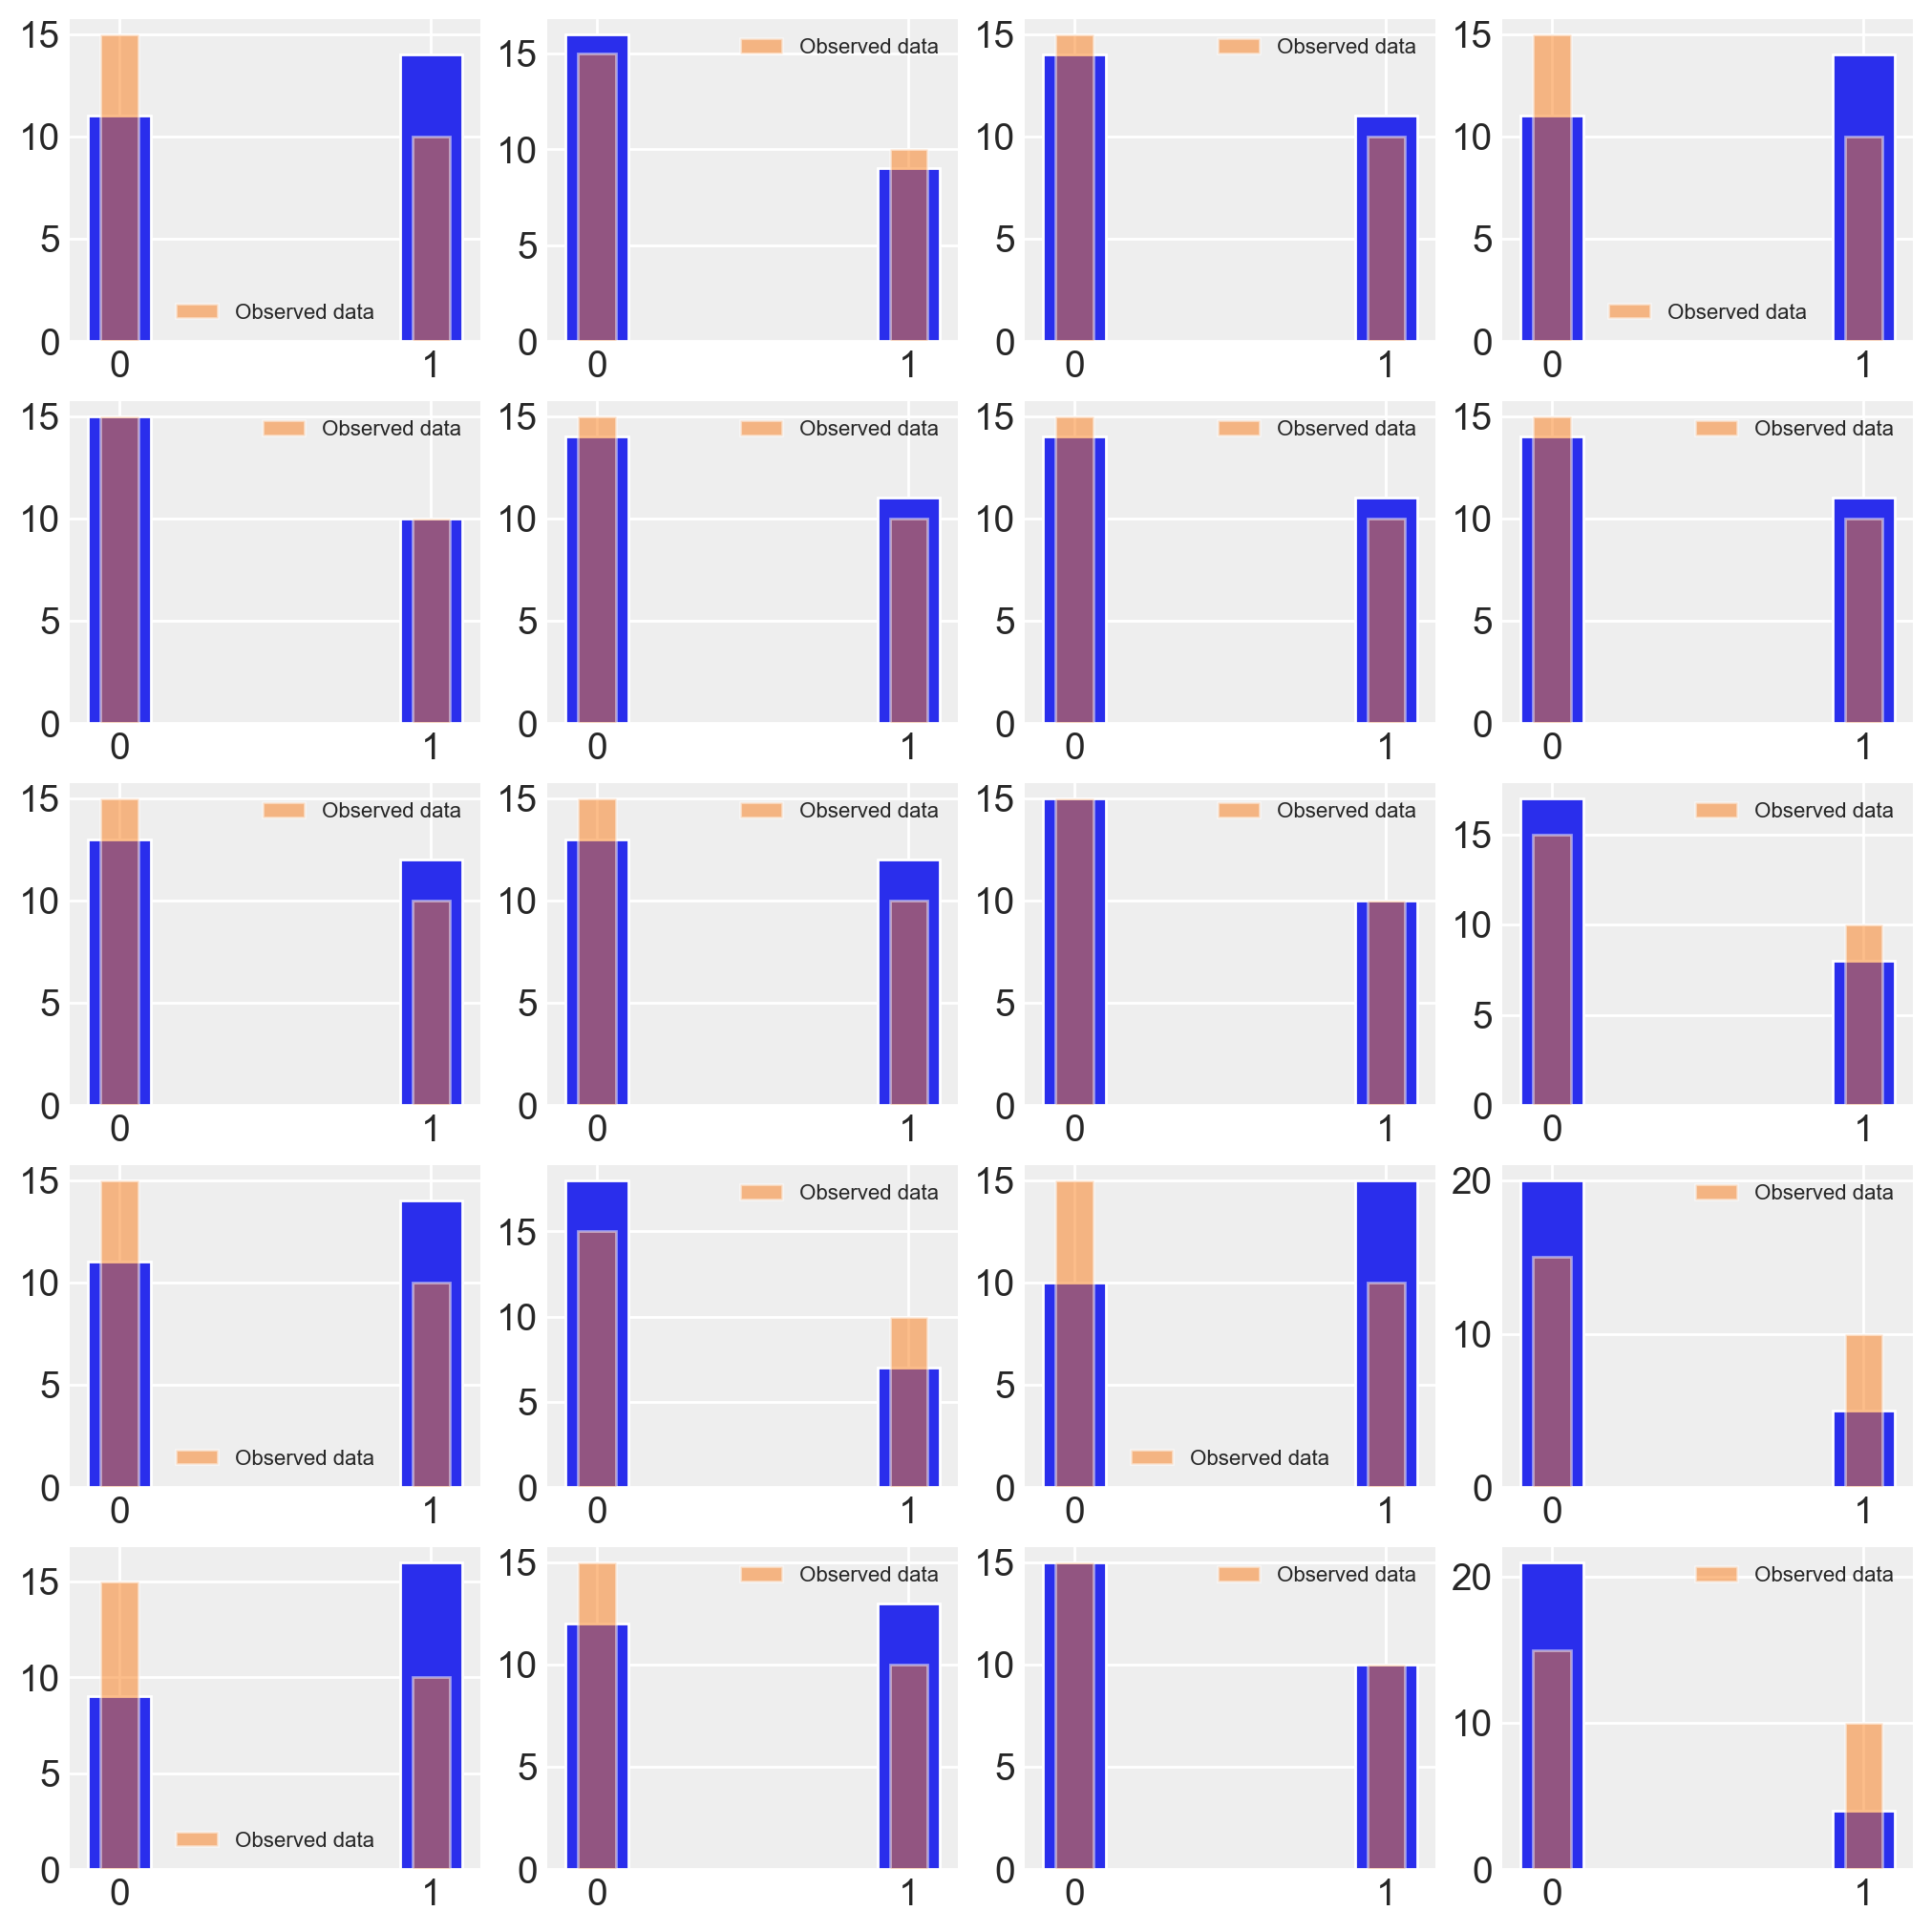

In [22]:
plt.figure( figsize=(10, 10) )
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.bar(*np.unique(x_post[i], return_counts=True), width=0.2)
    plt.bar(*np.unique(data, return_counts=True), width=0.12, 
            alpha=0.5, label='Observed data')
    plt.xticks([0, 1])
    plt.legend(loc='best', fontsize=8)

## Example 3 - Challenger Space Shuttle Disaster

Let's revisit this example from the MCMC lecture.

In [23]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

In [24]:
# load data 
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
print("Temp (F), O-Ring failure?")
print(challenger_data)

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


/var/folders/5y/28n32xmx0551k29hd21qs87c0000gp/T/ipykernel_44781/3265105615.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


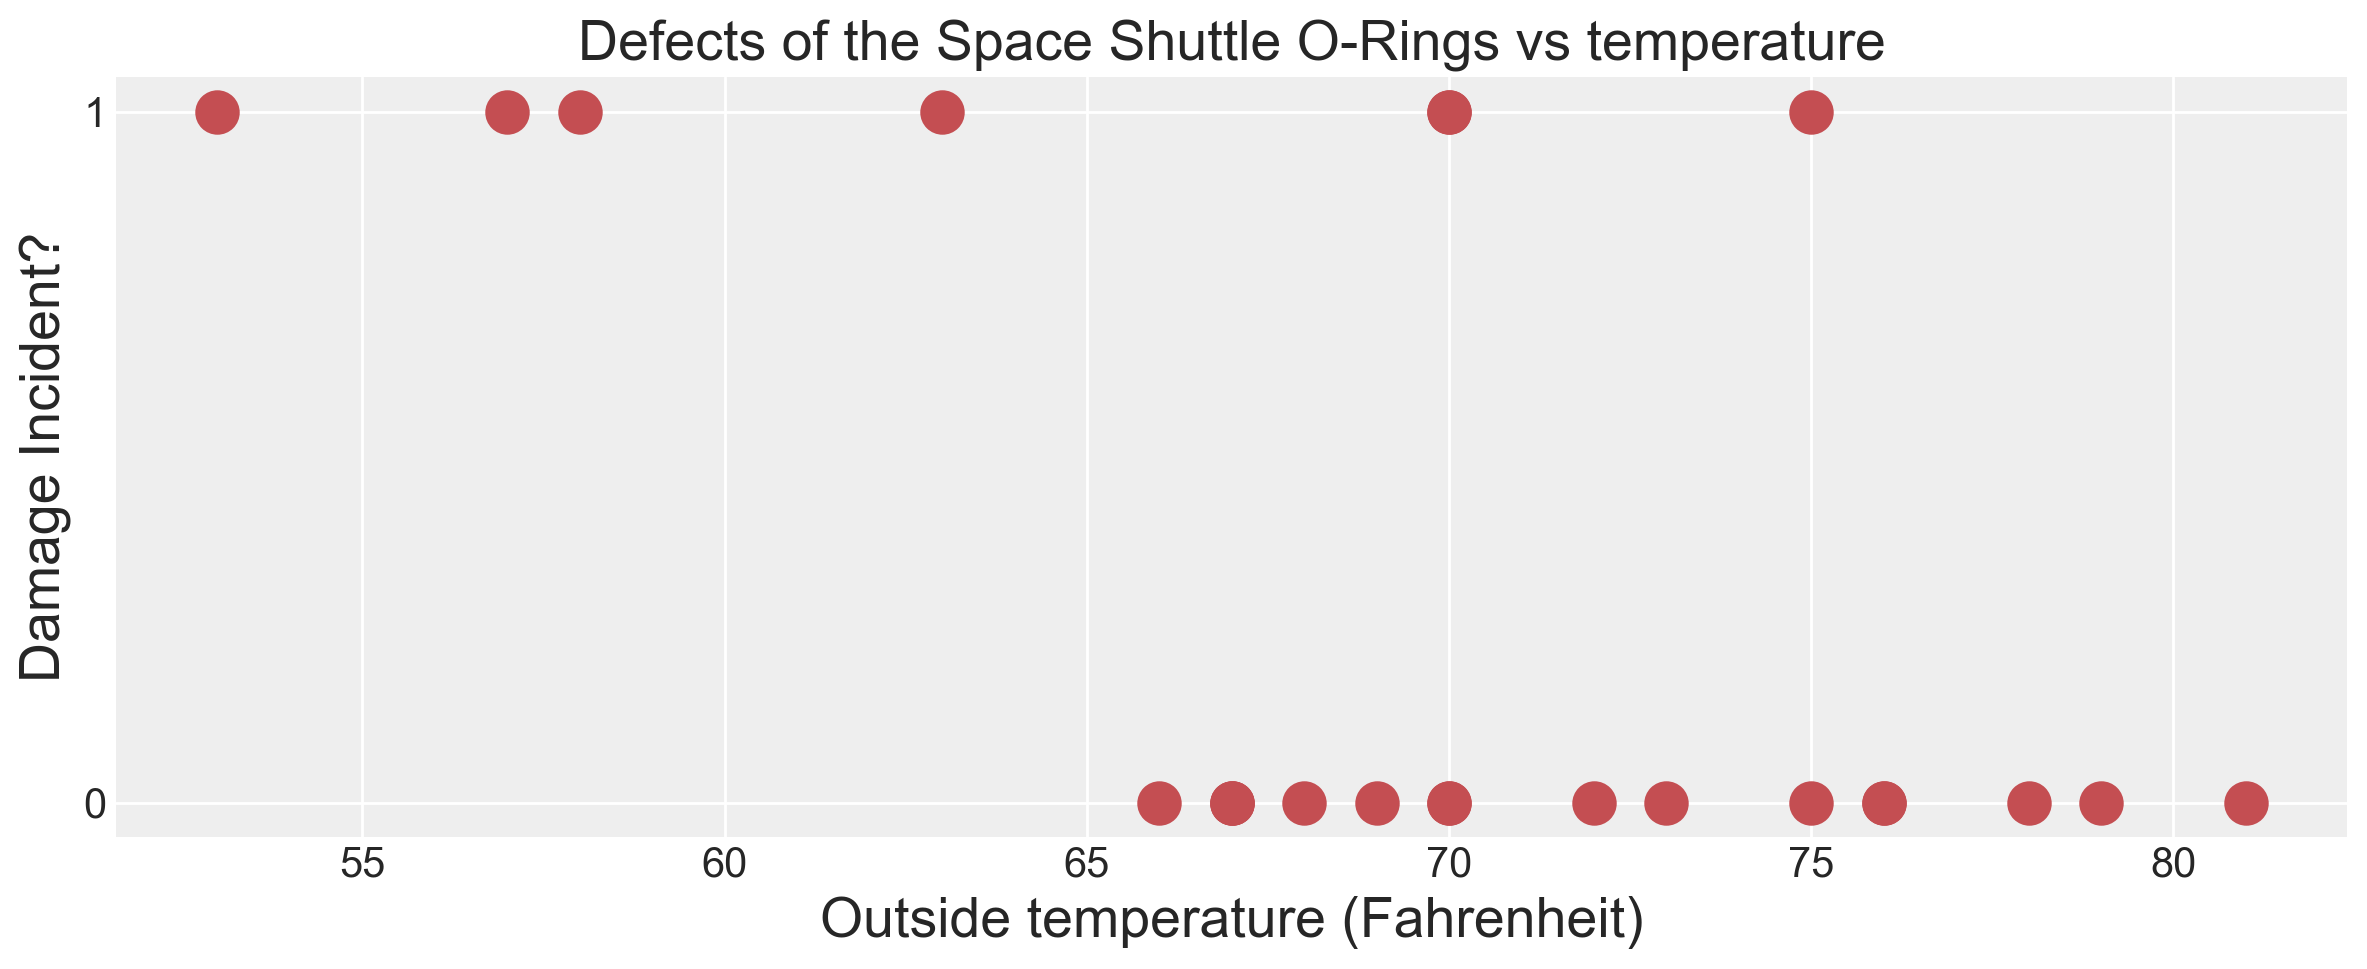

In [25]:
# plot it, as a function of temperature (the first column)
plt.figure(figsize=(12, 5))
plt.plot(challenger_data[:, 0], challenger_data[:, 1], 'ro', 
         markersize=15)
plt.ylabel("Damage Incident?",fontsize=20)
plt.xlabel("Outside temperature (Fahrenheit)",fontsize=20)
plt.title("Defects of the Space Shuttle O-Rings vs temperature",
          fontsize=20)
plt.yticks([0, 1], fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()

### Probabilistic model 

The defect probability is modeled as a function of the outside temperature:

$$\sigma(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$.

The goal is to infer the latent variables $\alpha$ and $\beta$. 

We set normal priors on the latent variables - $\alpha = \mathcal{N}(0, 10^2)$ and $\beta = \mathcal{N}(0, 10^2)$ and the likelihood model is giveb by $p(x_i | \alpha, \beta, t) = \mathrm{Bern}(x_i | \sigma(t; \alpha, \beta) )$.

The graphical model for this problem is shown below.

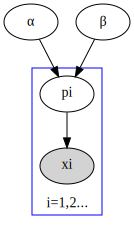

In [27]:
from graphviz import Digraph

gcp = Digraph('space_shuttle_disaster')

# setup the nodes 
gcp.node('alpha', label='<&alpha;>')
gcp.node('beta', label='<&beta;>')
with gcp.subgraph(name='cluster_0') as sg:
    sg.node('pi', label='<p<sub>i</sub>>')
    sg.node('xi', label='<x<sub>i</sub>>', style='filled')
    sg.attr(color='blue')
    sg.attr(label='i=1,2...')
    sg.attr(labelloc='b')

# setup the edges 
gcp.edge('alpha', 'pi')
gcp.edge('beta', 'pi')
gcp.edge('pi', 'xi')
gcp

###  `PyMC3` model 

In [28]:
# gather the data and apply preprocessing if any 
temp = challenger_data[:, 0]
temp_scaled = (temp - np.mean(temp))/np.std(temp)
data = challenger_data[:, 1]

# instantiate the pymc3 model
challenger_model = pm.Model()

# define the graph 
with challenger_model:
    # define the prior
    alpha = pm.Normal('alpha', mu=0., sigma=10.)
    beta = pm.Normal('beta', mu=0., sigma=10.)
    
    # get the probabilities of failure at each observed temp 
    p = pm.Deterministic('p', 1./(1. + tt.exp(alpha + beta*temp_scaled)))
    
    # define the likelihood 
    x = pm.Bernoulli('x', p=p, observed=data)
print("Challenger space shuttle disaster model:")
challenger_model

Challenger space shuttle disaster model:


### Inference and posterior visualization

Now let's infer the hidden parameters with VI. We will use both mean-field (i.e. diagonal covariance Gaussian) ADVI and full-rank (i.e. full rank covariance matrix Gaussian) ADVI. 

In [29]:
num_iter = 20000
num_samples = 20
with challenger_model:
    method_1 = pm.ADVI()  # <- This method makes q a diagonal Gaussian
    vi_approx_1 = pm.fit(n=num_iter, 
                       method=method_1,
                       progressbar=True, 
                       obj_n_mc=num_samples)

Finished [100%]: Average Loss = 15.668


In [31]:
with challenger_model:
    method_2 = pm.FullRankADVI()  # <- This method makes q a diagonal Gaussian
    vi_approx_2 = pm.fit(n=num_iter, 
                       method=method_2,
                       progressbar=True, 
                       obj_n_mc=num_samples)

Finished [100%]: Average Loss = 15.631


Let's make sure that the ELBO has converged.

/var/folders/5y/28n32xmx0551k29hd21qs87c0000gp/T/ipykernel_44781/356966444.py:21: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


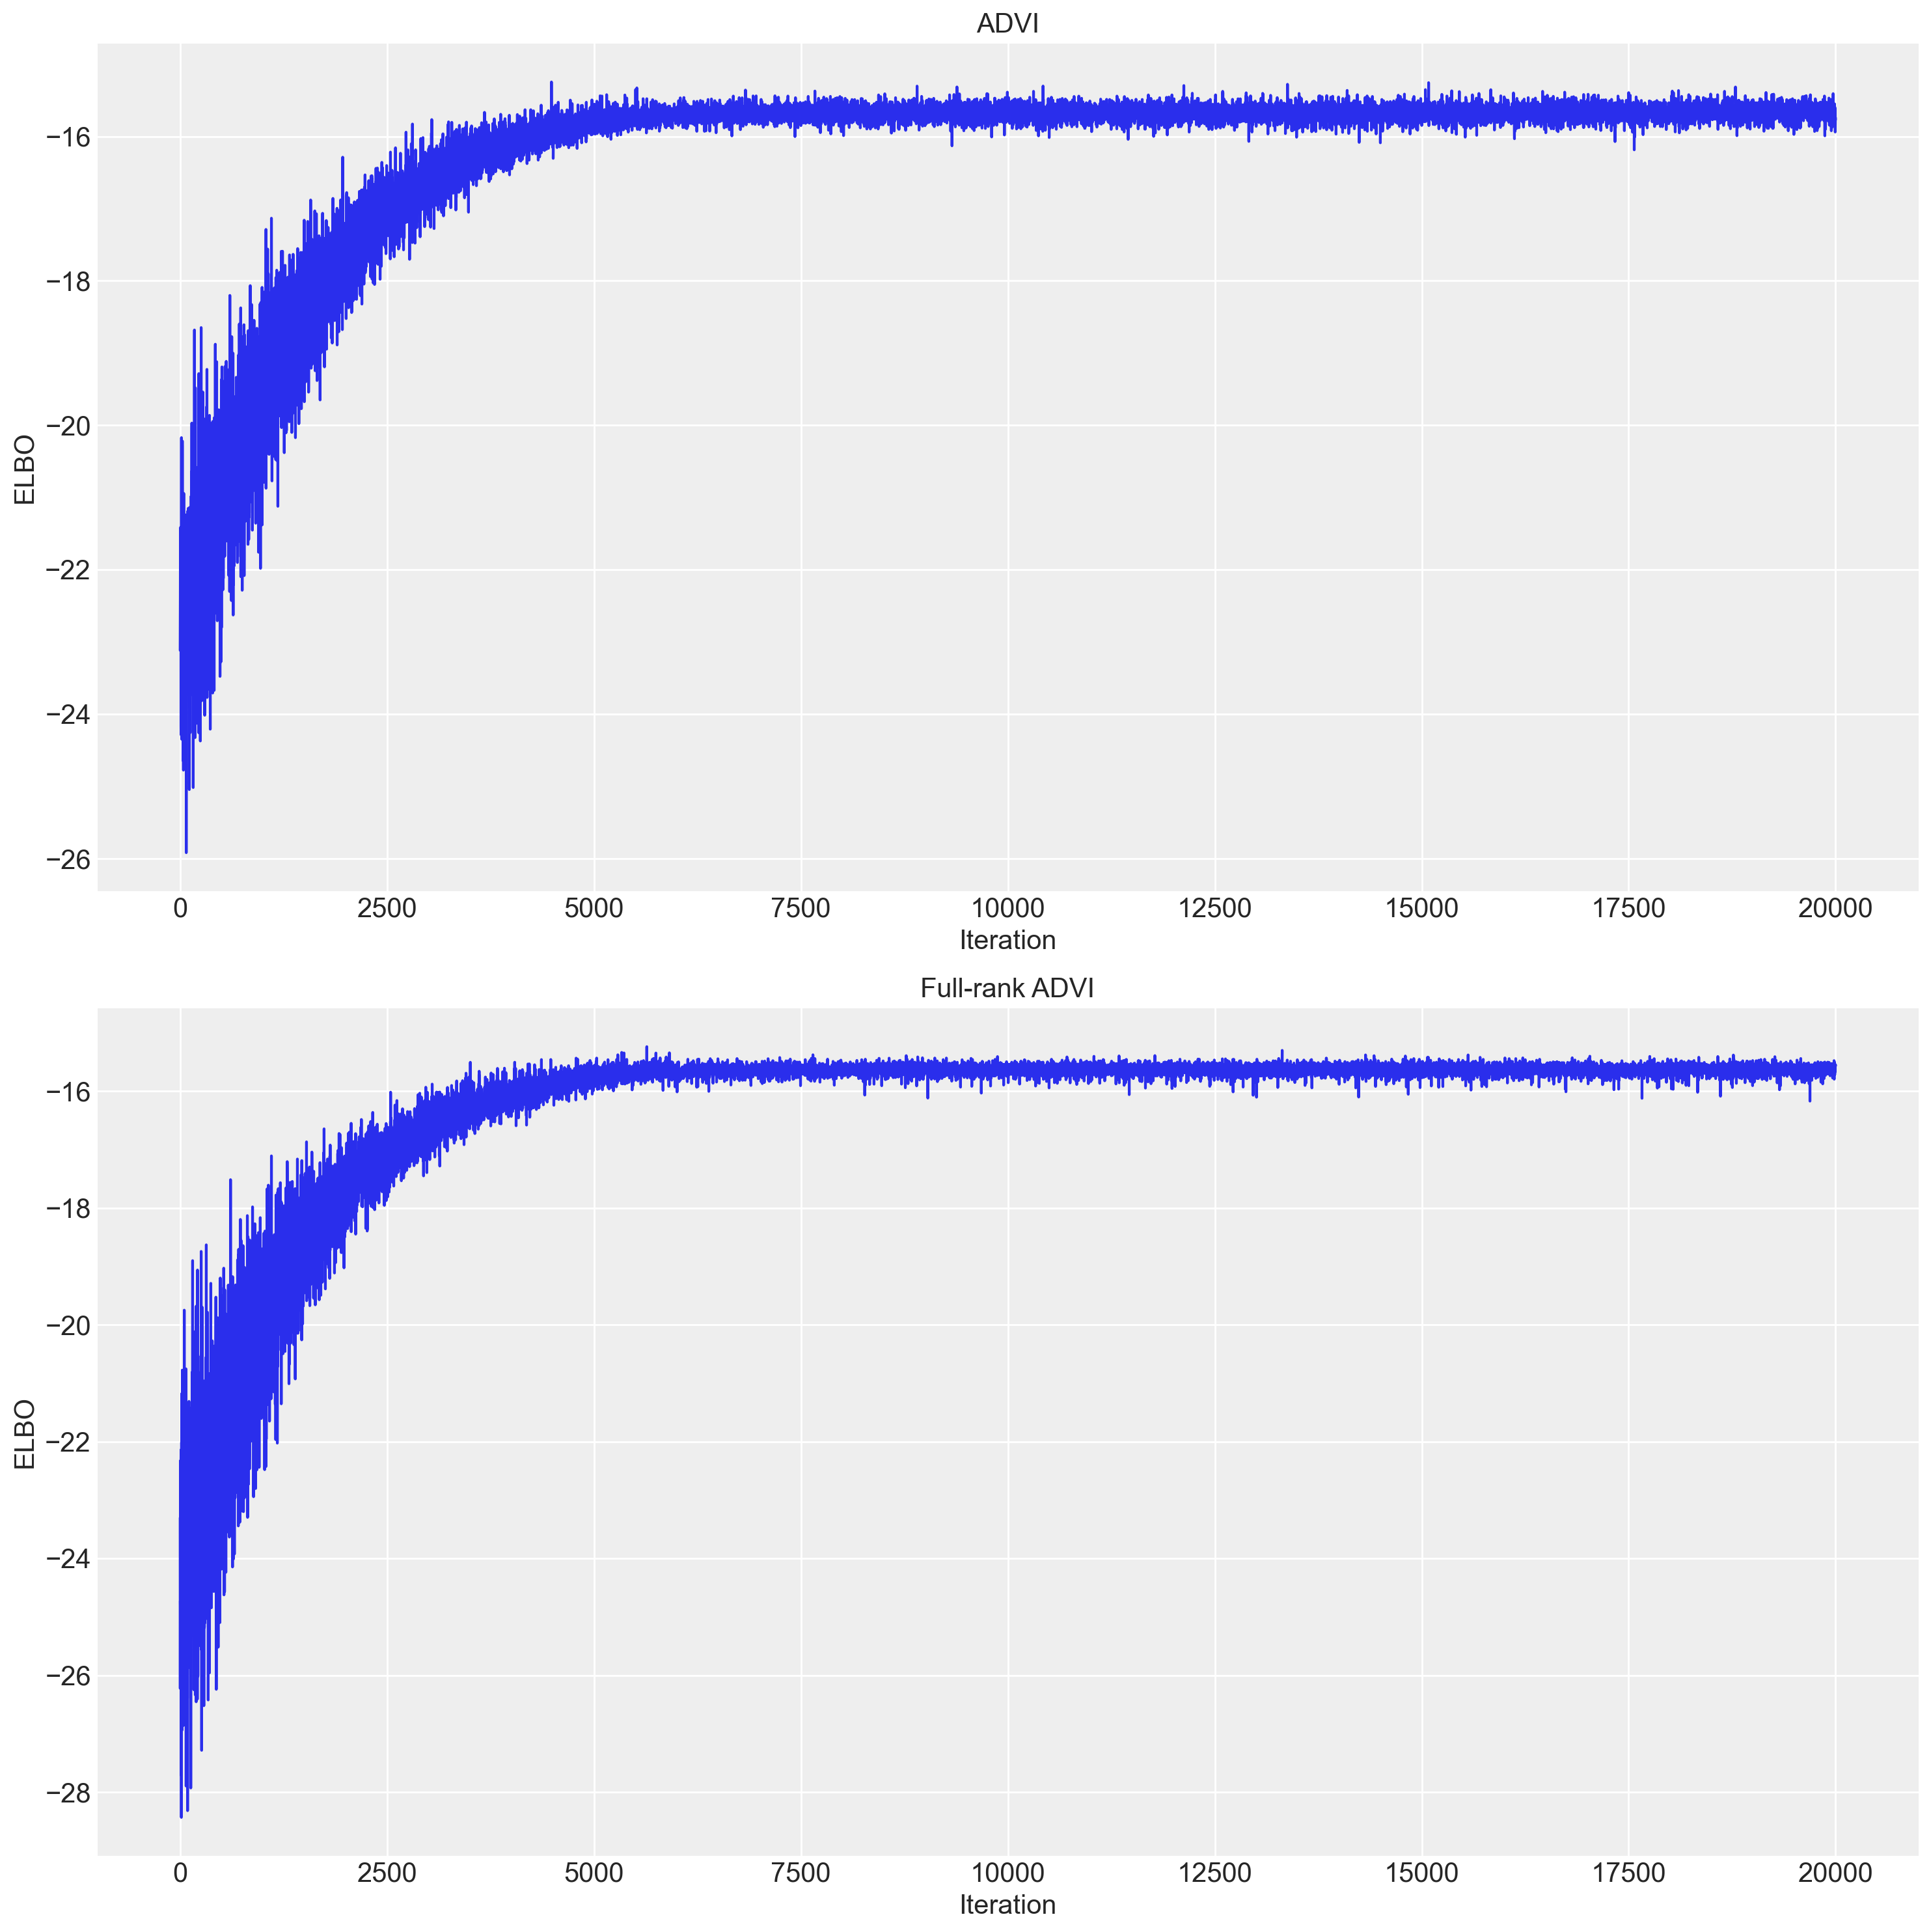

In [32]:
plt.figure(figsize=(15, 15))

# ADVI
plt.subplot(211)
plt.plot(np.arange(num_iter), -vi_approx_1.hist)
plt.ylabel('ELBO', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('ADVI', fontsize=15);

# Full rank ADVI
plt.subplot(212)
plt.plot(np.arange(num_iter), -vi_approx_2.hist)
plt.ylabel('ELBO', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Full-rank ADVI', fontsize=15)

plt.tight_layout()

We see that both methods have converged to a local minimum.

Let's get the variational posteriors $q$ for each case and compare.

In [33]:
# get the variational parameters and compute the post. pdf over a grid for ADVI
mu, sigma = vi_approx_1.mean.eval(), vi_approx_1.std.eval()
qtheta = pm.MvNormal.dist(mu=mu, cov=np.diag(sigma), shape=2)
x1max, x2max = mu + 3.*sigma
x1min, x2min = mu - 3.*sigma
x1 = np.linspace(x1min, x1max, 50)
x2 = np.linspace(x2min, x2max, 50)
names = [g.name for g in vi_approx_1.groups[0].group]
X1, X2 = np.meshgrid(x1, x2)
Xgrid = np.vstack([X1.flatten(), X2.flatten()]).T
advipdf = np.exp(qtheta.logp(tt.as_tensor(Xgrid)).eval()).reshape((50, 50))

In [34]:
# get the variational parameters and compute the post. pdf over a grid for full rank ADVI
mu, cov = vi_approx_2.mean.eval(), vi_approx_2.cov.eval()
sigma = np.sqrt(np.diag(cov))
qtheta = pm.MvNormal.dist(mu=mu, cov=cov, shape=2)

x1max, x2max = mu + 3.*sigma
x1min, x2min = mu - 3.*sigma
x1 = np.linspace(x1min, x1max, 50)
x2 = np.linspace(x2min, x2max, 50)
names = [g.name for g in vi_approx_2.groups[0].group]
X1, X2 = np.meshgrid(x1, x2)
Xgrid = np.vstack([X1.flatten(), X2.flatten()]).T
advifullrankpdf = np.exp(qtheta.logp(tt.as_tensor(Xgrid)).eval()).reshape((50, 50))

/var/folders/5y/28n32xmx0551k29hd21qs87c0000gp/T/ipykernel_44781/666848376.py:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


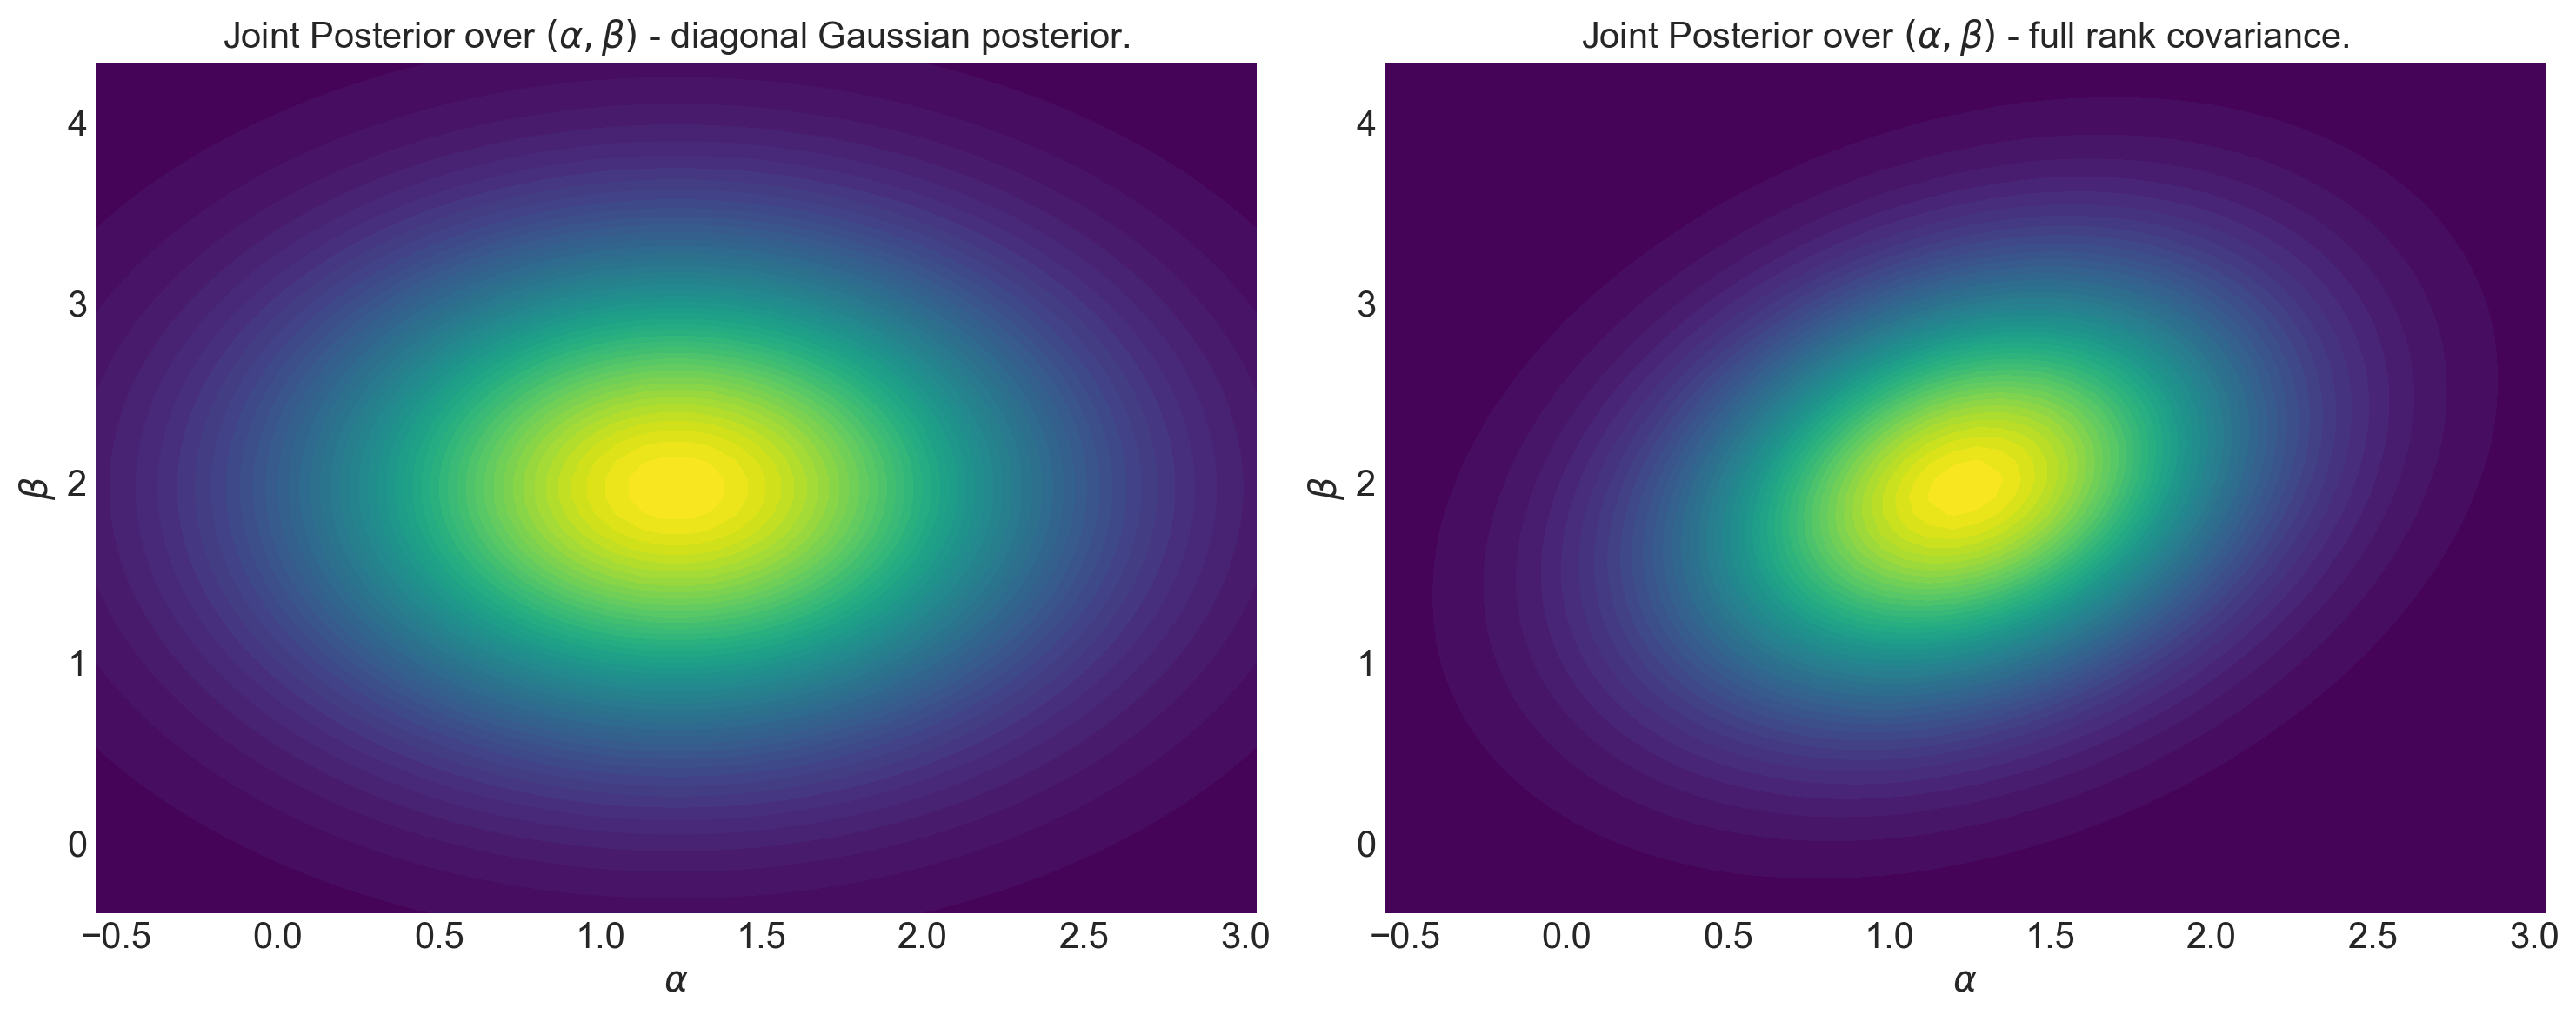

In [35]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.contourf(X1, X2, advipdf, 50)
plt.xlabel('$\\'+names[0]+'$', fontsize=15)
plt.ylabel('$\\'+names[1]+'$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Joint Posterior over $(\\alpha, \\beta)$ - diagonal Gaussian posterior.', fontsize=15)

plt.subplot(122)
plt.contourf(X1, X2, advifullrankpdf, 50)
plt.xlabel('$\\'+names[0]+'$', fontsize=15)
plt.ylabel('$\\'+names[1]+'$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Joint Posterior over $(\\alpha, \\beta)$ - full rank covariance.', fontsize=15)

plt.tight_layout()

Note how the simple diagonal Gaussian does not capture correlation between $\alpha$ and $\beta$,something we are able to recover with the full rank ADVI.

###  Posterior predictive distribution

Here we will use a trace generated from the full rank Gaussian posterior to make posterior predictions. 

In [36]:
trace = vi_approx_2.sample(10000)

with challenger_model:
    ppsamples = pm.sample_posterior_predictive(trace=trace, 
                                               samples=2000,
                                               var_names=['p'])['p']

/opt/homebrew/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [37]:
# get posterior predictive mean and 95% interval
ppmean = ppsamples.mean(axis=0)
pp_lower, pp_upper = np.percentile(ppsamples, axis=0, q=[2.5, 97.5])

/var/folders/5y/28n32xmx0551k29hd21qs87c0000gp/T/ipykernel_44781/1564772300.py:15: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


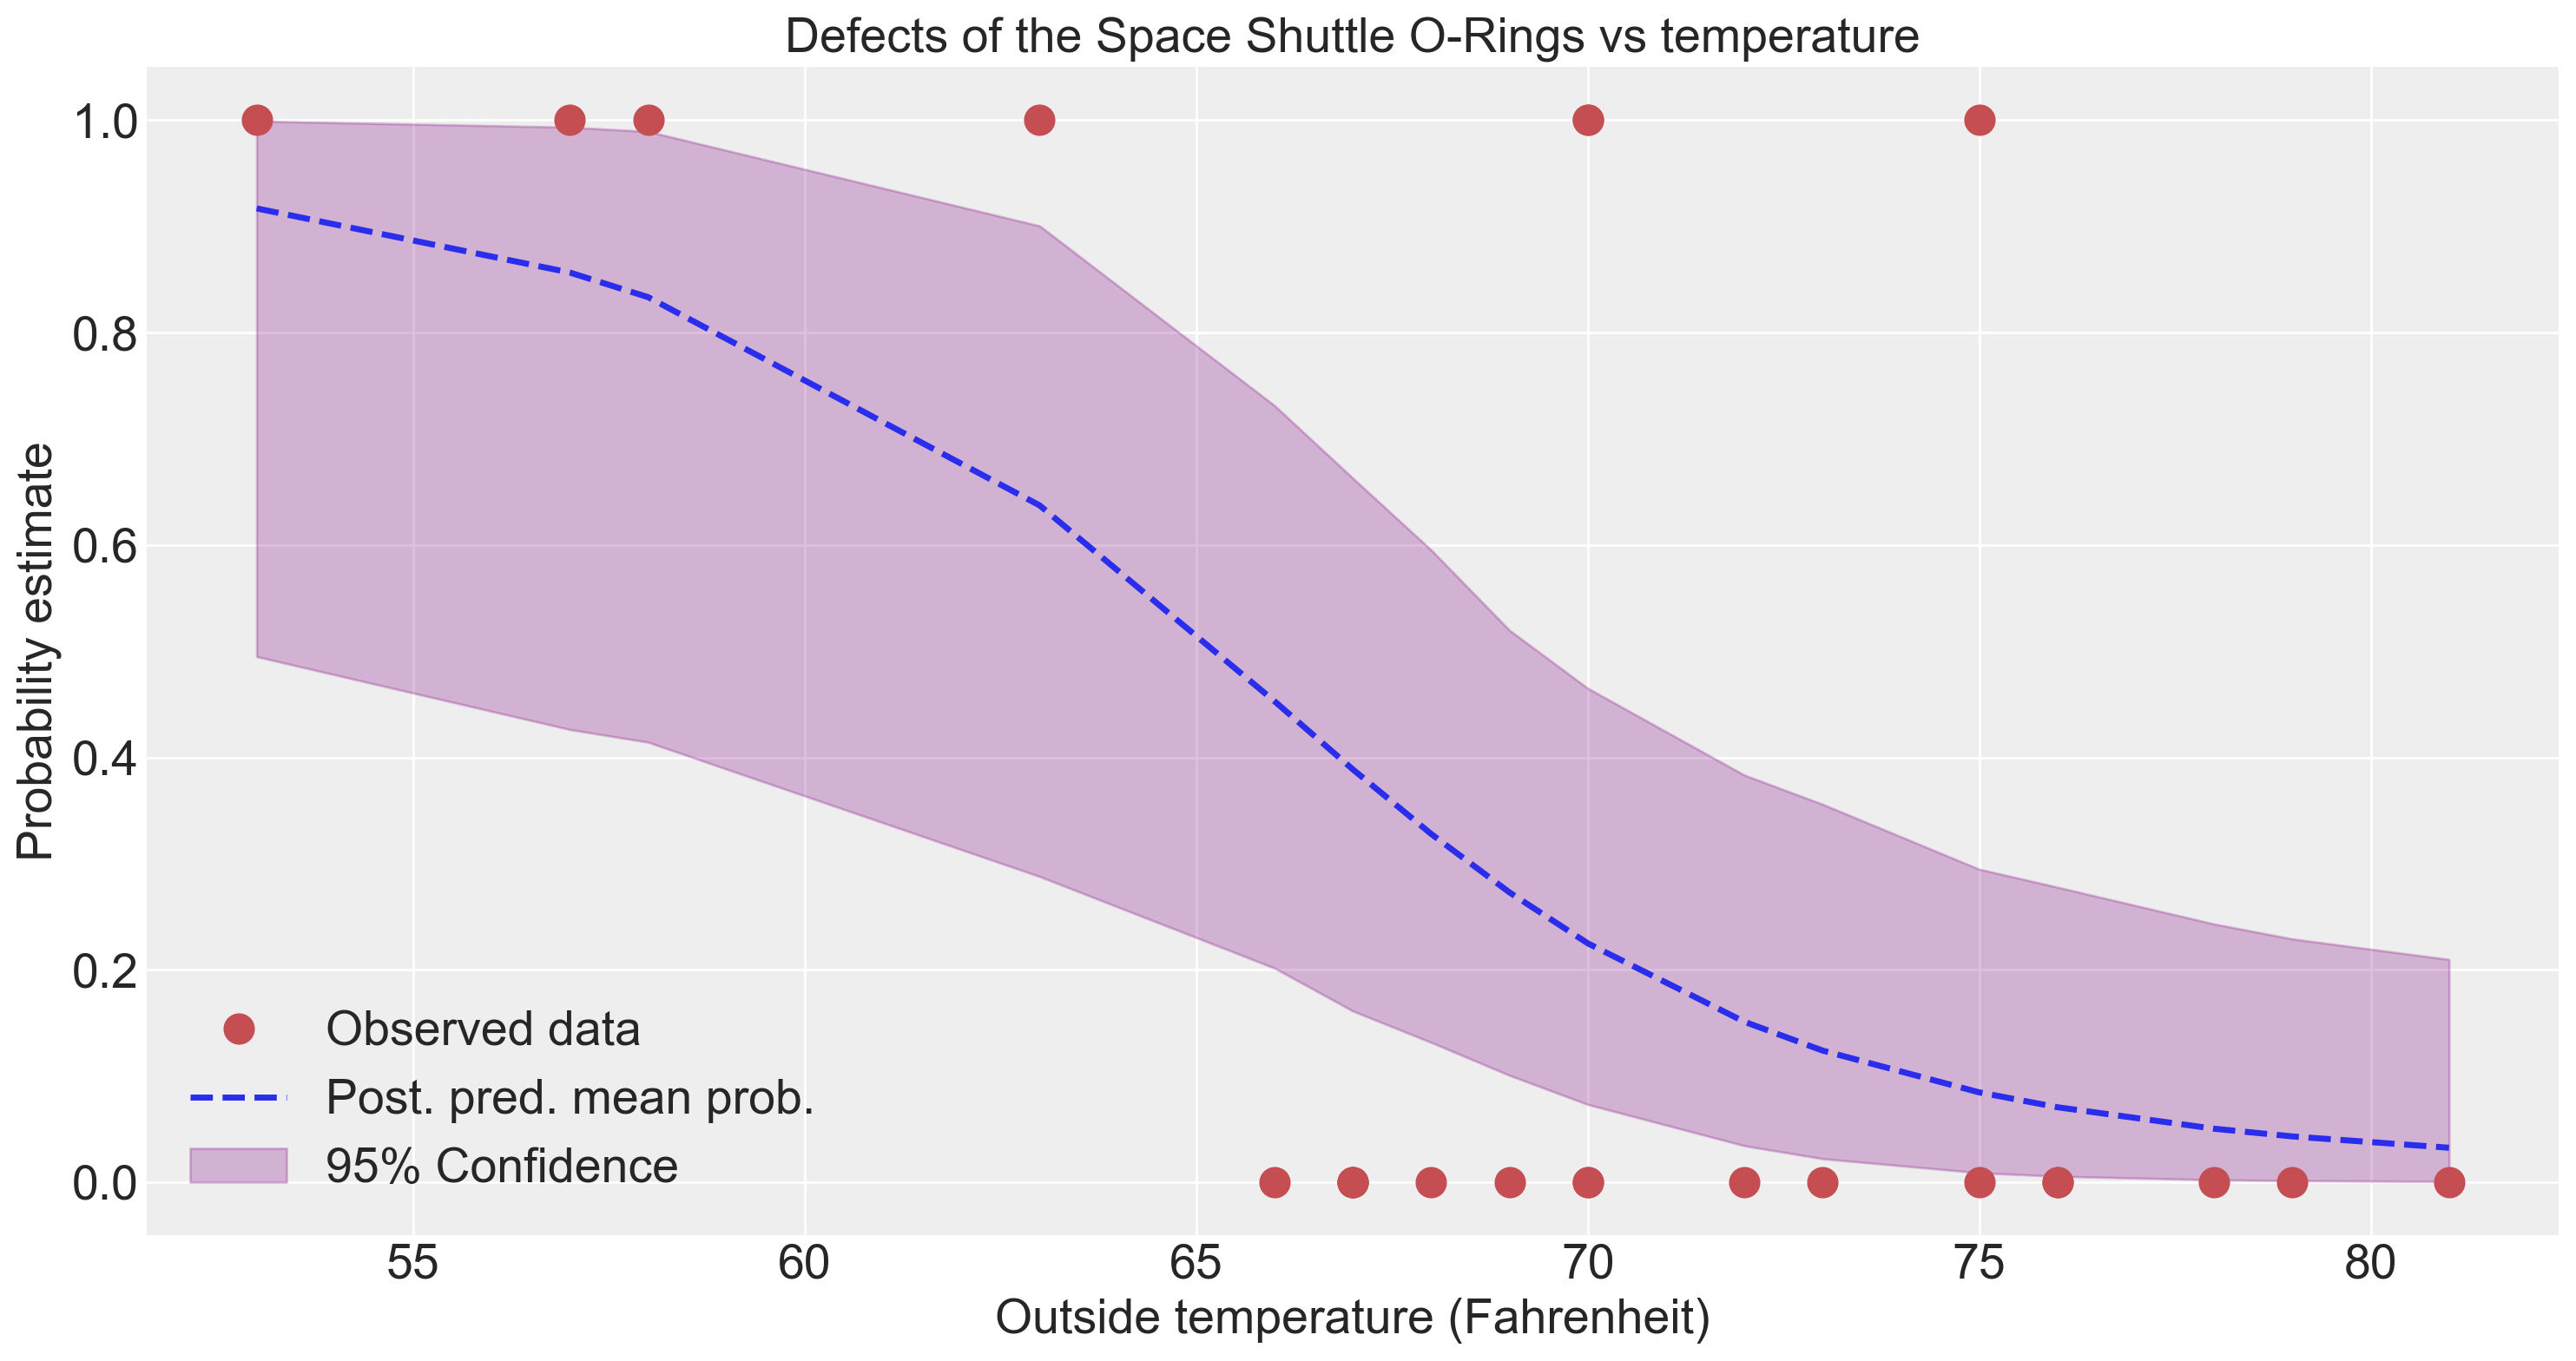

In [38]:
plt.figure(figsize=(15, 8))
plt.plot(temp, data, 'ro', markersize=12, label='Observed data')
idx=np.argsort(temp)
plt.plot(temp[idx], ppmean[idx], linestyle='--', linewidth=2.5, 
         label='Post. pred. mean prob.')
plt.fill_between(temp[idx], pp_lower[idx], pp_upper[idx], 
                color='purple', alpha=0.25, label='95% Confidence')
plt.ylabel("Probability estimate",fontsize=20)
plt.xlabel("Outside temperature (Fahrenheit)",fontsize=20)
plt.title("Defects of the Space Shuttle O-Rings vs temperature",
          fontsize=20)
plt.yticks(np.arange(0., 1.01, 0.2), fontsize=20)
plt.xticks(fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.tight_layout()